In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles

In [2]:
n_samples = 1000
X, y = make_circles(n_samples=n_samples, noise=0.03, random_state=41)

In [3]:
# plt.plot(X, y, c=y)
# X[:5], y[:5]
len(X[:, 0]),len(X[:,1]), len(y)

(1000, 1000, 1000)

In [4]:
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

circles.head()

,X1,X2,label
0,-0.918707,0.365705,0
1,0.794461,0.184218,1
2,-0.359628,-0.692222,1
3,0.982318,-0.199475,0
4,-0.461588,0.706247,1


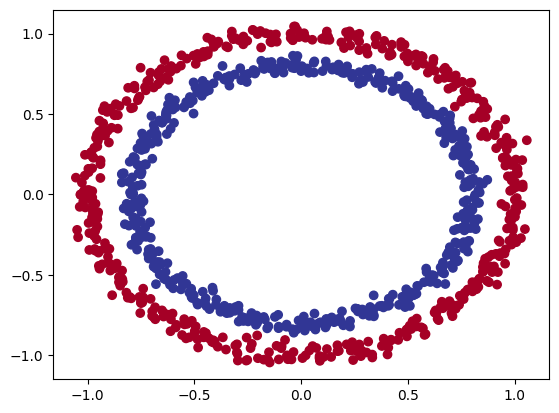

In [5]:
plt.scatter(circles.X1, circles.X2, c=circles.label, cmap=plt.cm.RdYlBu)

In [6]:
# X = torch.from_numpy(X.astype(np.float32))
# y = torch.from_numpy(y.astype(np.float32))

X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [7]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [8]:
X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)
X_train.dtype

torch.float32

In [10]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [12]:
from torch import nn
class CircleModelV0(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layer1 = nn.Linear(2, 5)
        self.layer2 = nn.Linear(5, 1)
        
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.layer2(
            torch.relu(self.layer1(X))
            )

In [13]:
model_v0 = CircleModelV0().to(device)
list(model_v0.parameters())

[Parameter containing:
 tensor([[-0.1129,  0.5209],
         [ 0.0518,  0.1590],
         [ 0.5902,  0.4950],
         [ 0.3294,  0.6757],
         [ 0.6747,  0.3445]], requires_grad=True),
 Parameter containing:
 tensor([-0.6229,  0.2431, -0.0459,  0.5109, -0.2123], requires_grad=True),
 Parameter containing:
 tensor([[-0.1056, -0.0826,  0.1467, -0.2364,  0.2834]], requires_grad=True),
 Parameter containing:
 tensor([-0.2231], requires_grad=True)]

In [14]:
model_v0.state_dict()

OrderedDict([('layer1.weight',
              tensor([[-0.1129,  0.5209],
                      [ 0.0518,  0.1590],
                      [ 0.5902,  0.4950],
                      [ 0.3294,  0.6757],
                      [ 0.6747,  0.3445]])),
             ('layer1.bias',
              tensor([-0.6229,  0.2431, -0.0459,  0.5109, -0.2123])),
             ('layer2.weight',
              tensor([[-0.1056, -0.0826,  0.1467, -0.2364,  0.2834]])),
             ('layer2.bias', tensor([-0.2231]))])

In [15]:
device

'cpu'

In [16]:
next(iter(model_v0.parameters())).device

device(type='cpu')

In [17]:
model_v1 = nn.Sequential(
    nn.Linear(2, 10),
    nn.Linear(10, 10),
    nn.Linear(10, 1),
    nn.ReLU(),
).to(device)  



In [18]:
un_trained_preds = model_v1(X_train.to(device))
un_trained_preds.shape


torch.Size([800, 1])

In [19]:
optmi_fn = torch.optim.SGD(model_v1.parameters(), lr = 0.1)

loss_fn = nn.BCEWithLogitsLoss()

In [20]:
def accuracy_fn(y, y_hat):
    correct = torch.eq(y, y_hat).sum().item()
    acc = (correct / len(y)) * 100
    return acc

In [21]:
# model_v1.eval()
with torch.inference_mode():
    y_logits = model_v1(X_test.to(device))
y_logits[:5]

tensor([[0.1764],
        [0.1248],
        [0.0452],
        [0.0000],
        [0.1683]])

In [22]:
y_test[:5]

tensor([0., 0., 1., 0., 1.])

In [23]:
y_probs = torch.round(torch.sigmoid(y_logits))


In [24]:

# y_probs == y_test
torch.eq(y_probs, y_test)

tensor([[False, False,  True,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False],
        ...,
        [ True,  True, False,  ...,  True,  True,  True],
        [False, False,  True,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False]])

In [25]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [26]:

epochs = 500
torch.manual_seed(43)
torch.cuda.manual_seed(43)

epoch_list = []
train_loss_list = []
loss_list = []
acc_list = []

for epoch in range(epochs):
    model_v1.train()
    
    y_logits = model_v1(X_train.to(device)).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    
    train_loss = loss_fn(y_logits, y_train.to(device))
    train_acc = accuracy_fn(y_train, y_preds)


    optmi_fn.zero_grad()
    train_loss.backward()
    optmi_fn.step()

    model_v1.eval()
    with torch.inference_mode():
        y_logits_test = model_v1(X_test.to(device)).squeeze()
        y_probs_test = torch.round(torch.sigmoid(y_logits_test))


    if epoch % 10 == 0:
        test_loss = loss_fn(y_logits_test, y_test.to(device))
        test_acc = accuracy_fn(y_test, y_probs_test)

        epoch_list.append(epoch)
        train_loss_list.append(train_loss.item())
        loss_list.append(test_loss)
        acc_list.append(test_acc)  




In [27]:
train_loss_list[:5]

[0.6987646222114563,
 0.6965888142585754,
 0.693174421787262,
 0.6931524872779846,
 0.6931506395339966]

In [28]:
loss_list[:5]

[tensor(0.6962),
 tensor(0.6951),
 tensor(0.6932),
 tensor(0.6931),
 tensor(0.6931)]

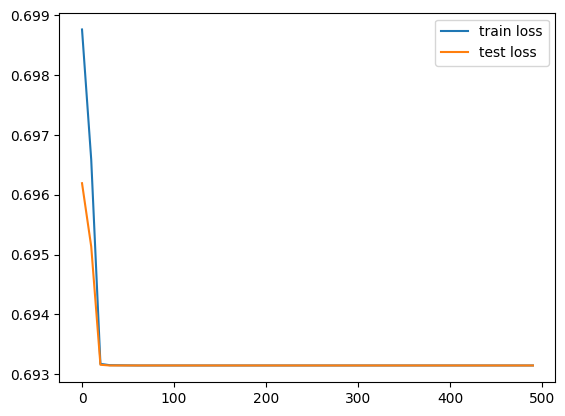

In [29]:
plt.plot(epoch_list,train_loss_list, label="train loss")
plt.plot(epoch_list,loss_list, label="test loss")
plt.legend()

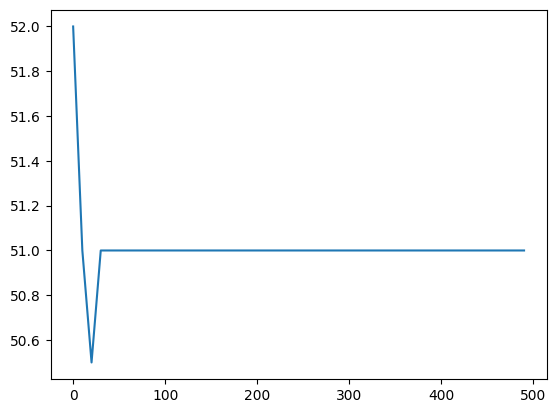

In [30]:
plt.plot(epoch_list, acc_list, label="test acc")

In [31]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


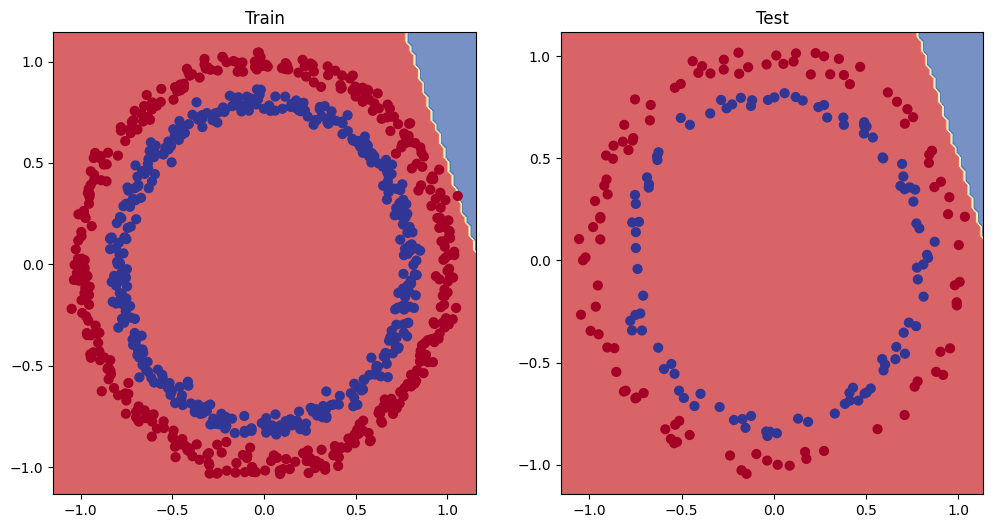

In [32]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_v1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_v1, X_test, y_test)